In [125]:
%pylab inline

rcParams["figure.figsize"] = (12, 9) #<--- large default figures

# Plot text elements
rcParams['axes.labelsize'] = 17
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# 1. Read tweets appearing on homepage

In [126]:
import tweepy

consumer_key = 'JElhoUDXi9BFsfCTVERhc9Vb1'
consumer_secret = 'CPws1P5KCYWbVePYKN0FpBmiSV1hvcow4x4O1lwRS4G1U31Jxl'

access_token ='3773670734-SHThwjiBZVvI34rdjWn7lGgCAM2YHLOL0OPCrrC'
access_token_secret = 'gGHhMkrKCOVQhvMRTOB0asLE7ZFIsNmcjN8s0rAZIqY07'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

public_tweets = api.home_timeline()
for (idx, tweet) in enumerate(public_tweets[0:3]): #First 3 tweets in my public feed
    print ('TWEET', idx, ': ', tweet.text)

TWEET 0 :  The message is crucial: wear your safety pin, but make sure it is an honest signal of your willingness to act.
TWEET 1 :  We asked 9 experts to lay out their advice and concerns ahead of the next US administration, here's what they said… https://t.co/vDjqrPdqxV
TWEET 2 :  If your goal is to persuade your white friends, be aware that this piece may disengage potential allies. Don't let… https://t.co/s34bDdXvmf


In [135]:
# The following code is taken from Alexander Galea's blog:
# https://galeascience.wordpress.com/2016/03/18/collecting-twitter-data-with-python/

import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import sys


'''
The main() function can be run by executing the command: 
python twitter_search.py
'''

def load_api():
    ''' Function that loads the twitter API after authorizing the user. '''

    consumer_key = 'JElhoUDXi9BFsfCTVERhc9Vb1'
    consumer_secret = 'CPws1P5KCYWbVePYKN0FpBmiSV1hvcow4x4O1lwRS4G1U31Jxl'
    access_token = '3773670734-SHThwjiBZVvI34rdjWn7lGgCAM2YHLOL0OPCrrC'
    access_secret = 'gGHhMkrKCOVQhvMRTOB0asLE7ZFIsNmcjN8s0rAZIqY07'
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    # load the twitter API via tweepy
    api = tweepy.API(auth)
    return api
    # show the tweepy rate limits
    print (api.rate_limit_status())

    
def tweet_search(api, query, max_tweets, max_id, since_id, geocode):
    ''' Function that takes in a search string 'query', the maximum
        number of tweets 'max_tweets', and the minimum (i.e., starting)
        tweet id. It returns a list of tweepy.models.Status objects. '''

    searched_tweets = []
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
				                    max_id=str(max_id-1))
#                                    geocode=geocode)
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id


def get_tweet_id(api, date='', days_ago=9, query='a'):
    ''' Function that gets the ID of a tweet. This ID can then be
        used as a 'starting point' from which to search. The query is
        required and has been set to a commonly used word by default.
        The variable 'days_ago' has been initialized to the maximum
        amount we are able to search back in time (9).'''

    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id


def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''

    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')


def main():
    ''' This is a script that continuously searches for tweets
        that were created over a given number of days. The search
        dates and search phrase can be changed below. '''



    ''' search variables: '''
    search_phrases = ['#imwithher', 
                      '#makeamericagreatagain',
                      '#nevertrump',
                      '#neverhillary',
                      '#election2016',
                      '#maga',
                      '#ivoted',
                      '#hillaryclinton',
                      '#donaldtrump',
                      '#makedonalddrumpfagain']
    
    # Specify search limits: a maximum number of days old (up to about 8) 
    # and a minimum number of days (as low as 0 i.e., “right now”). Collecting tweets over only 
    # one-day intervals is beneficial because each day is exported into its own file.
    
    time_limit = 0.1                           # runtime limit in hours (0.1 hours = 6 minutes)
    max_tweets = 100                           # number of tweets per each search (will be
                                               # iterated) - maximum is 100
    min_days_old, max_days_old = 8, 9          # search limits e.g., from 7 to 8
                                               # gives current weekday from last week,
                                               # min_days_old=0 will search from right now
    USA = '39.8,-95.583068847656,2500km'       # this geocode includes all lower 48 American
                                               # states (and a large portion of Mexico and Canada)
    
    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = load_api()
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)
        


        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id,
                                          geocode=USA)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break


if __name__ == "__main__":
    main()

Search phrase = #imwithher
Appending tweets to file named:  #imwithher/#imwithher_2016-11-04.json
Searching from the bottom ID in file
search limit (start/stop): 2016-11-03 23:59:59
max id (starting point) = 794690220528570368
since id (ending point) = 794328302987202560
count = 1
found 100 tweets
count = 2
found 100 tweets
count = 3
found 100 tweets
count = 4
found 100 tweets
count = 5
found 100 tweets
count = 6
found 100 tweets
count = 7
found 100 tweets
count = 8
found 100 tweets
count = 9
found 95 tweets
found 4 tweets
found 1 tweets
count = 10
found 100 tweets
count = 11
found 100 tweets
count = 12
found 100 tweets
count = 13
found 98 tweets
found 2 tweets
count = 14
found 100 tweets
count = 15
found 100 tweets
count = 16
found 100 tweets
count = 17
found 100 tweets
count = 18
found 100 tweets
count = 19
found 100 tweets
count = 20
found 100 tweets
count = 21
found 100 tweets
count = 22
found 100 tweets
count = 23
found 100 tweets
count = 24
found 100 tweets
count = 25
found 99 tw

SystemExit: Maximum number of empty tweet strings reached - exiting

To exit: use 'exit', 'quit', or Ctrl-D.


In [150]:
%cd '/Users/evelyn/Workspaces/springboard/capstone/electiontweets'

/Users/evelyn/Workspaces/springboard/capstone/electiontweets


In [141]:
import json

tweet_files = ['#donaldtrump_2016-11-04.json',
               '#donaldtrump_2016-11-04.json',
               '#election2016_2016-11-04.json',
               '#hillaryclinton_2016-11-04.json',
               '#imwithher_2016-11-04.json',
               '#ivoted_2016-11-04.json',
               '#maga_2016-11-04.json',
               '#makeamericagreatagain_2016-11-04.json',
               '#makedonalddrumpfagain_2016-11-04.json',
               '#neverhillary_2016-11-04.json',
               '#nevertrump_2016-11-04.json']

tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f:
            tweets.append(json.loads(line))

In [142]:
tweets[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Nov 04 23:59:57 +0000 2016',
 'entities': {'hashtags': [{'indices': [31, 40], 'text': 'American'},
   {'indices': [52, 66], 'text': 'Dontvotetrump'},
   {'indices': [67, 79], 'text': 'donaldtrump'}],
  'symbols': [],
  'urls': [{'display_url': 'trib.al/IWZR2Wn',
    'expanded_url': 'http://trib.al/IWZR2Wn',
    'indices': [0, 23],
    'url': 'https://t.co/YUenkAev45'}],
  'user_mentions': [{'id': 8736882,
    'id_str': '8736882',
    'indices': [80, 93],
    'name': 'The Globe and Mail',
    'screen_name': 'globeandmail'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 794690681864220672,
 'id_str': '794690681864220672',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': No

In [117]:
import json
from pprint import pprint
 
tweet_files = ['#imwithher_2016-10-31.json', 'makeamericagreatagain_2016-10-31']
tweets = []

#for file in tweet_files:
#    #file = open('tweet_files', 'r')
#    file = file.read('tweet_files','r')
#    #print file.read()

with open('#imwithher_2016-10-31.json') as data_file:    
    data = json.load(data_file)

pprint(data)

JSONDecodeError: Extra data: line 2 column 1 (char 8475)

In [179]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
 
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
 
    df['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
 
    df['country_code'] = list(map(lambda tweet: tweet['place']['country_code']
                                  if tweet['place'] != None else '', tweets))
 
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
 
    df['lat'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
 
    return df

loc_df = populate_tweet_df(tweets)

In [180]:
loc_df[loc_df.notnull()]

,text,location,country_code,long,lat
0,https://t.co/YUenkAev45 Please #American neigh...,"Edmonton, Canada",,NaN,NaN
1,#DonaldTrump destrozaría la economía de Estado...,,,NaN,NaN
2,RT @TUshortnote: สรุปนโยบาย #HillaryClinton VS...,snapchat : ohmatichattt♡♡♡♡♡♡,,NaN,NaN
3,RT @VickyBrush: .#DonaldTrump is not political...,,,NaN,NaN
4,Are you for or against a wall ?#DonaldTrump #H...,,,NaN,NaN
5,"#DonaldTrump Says: Join me in Denver, Colorado...",United States,,NaN,NaN
6,https://t.co/ywbYZIRQm7 I don't know how this ...,United States,,NaN,NaN
7,#Ipredict #Hillary will Win by a healthy margi...,,,NaN,NaN
8,"#Clump says ""#HappyFriday to indecisive #voter...",,,NaN,NaN
9,RT @VickyBrush: .#DonaldTrump is not political...,Merdyth hill rd,,NaN,NaN


In [153]:
len(tweets)

121503

In [161]:
df = pd.DataFrame(tweets)
list(df.columns.values)

['contributors',
 'coordinates',
 'created_at',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'metadata',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

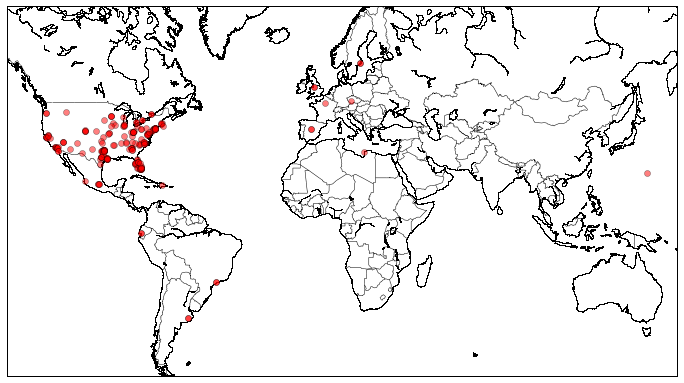

In [182]:
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
 
# plot the blank world map
my_map = Basemap(projection='merc', lat_0=50, lon_0=-100,
                     resolution = 'l', area_thresh = 5000.0,
                     llcrnrlon=-140, llcrnrlat=-55,
                     urcrnrlon=160, urcrnrlat=70)
# set resolution='h' for high quality
 
# draw elements onto the world map
my_map.drawcountries()
#my_map.drawstates()
my_map.drawcoastlines(antialiased=False,
                      linewidth=0.005)
 
# add coordinates as red dots
longs = list(loc_df.loc[(loc_df.long != 'NaN')].long)
lats = list(loc_df.loc[loc_df.lat != 'NaN'].lat)
x, y = my_map(longs, lats)
my_map.plot(x, y, 'ro', markersize=6, alpha=0.5)
 
plt.show()